## PySDM

In [1]:
import sys, os
os.environ["NUMBA_DISABLE_JIT"] = "1"

import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity, UniformRandom

from PySDM.products.size_spectral import ParticleVolumeVersusRadiusLogarithmSpectrum, ParticleSizeSpectrumPerVolume
import PySDM.products.size_spectral.arbitrary_moment as am
from PySDM.products.housekeeping.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Gamma, Exponential
from PySDM.dynamics.collisions.collision_kernels import ConstantK, Golovin
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import AlwaysN
from PySDM.physics.constants import si
from PySDM.physics.constants_defaults import rho_w, rho_STP
from PySDM import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

from scipy.stats import gamma

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx, array[idx])

In [3]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**15
        self.n_part = 10 / si.cm**3
        self.r_scale = 15 * si.um
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 600 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 4*3600.0]
        self.kernel = ConstantK(a=1e-4 * si.cm**3 / si.s)
        self.coal_eff = ConstEc(Ec=1.0)
        self.fragmentation = AlwaysN(n=1)
        self.break_eff = ConstEb(0.0) # no "bouncing"
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=Formulae().trivia.volume(self.r_scale))
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(1000 * si.um), num=128, endpoint=True)
        self.volume_bins_edges = self.radius_bins_edges**3 * 4 * np.pi / 3
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

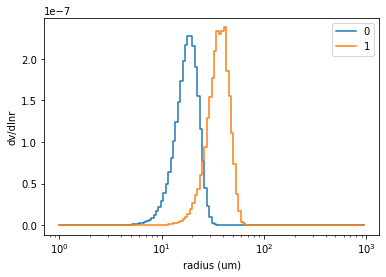

In [4]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
# env['rhod'] = 1
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
products = [dvdlnr, nv]
core = builder.build(attributes, products)
sdm_y = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_y1 = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
i = 0
v_cutoff = 1e3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]
dr = settings.radius_bins_edges[1:] - settings.radius_bins_edges[:-1]
for step in settings.output_steps:
    core.run(step - core.n_steps)
    sdm_y[:,i] = core.products['N(v)'].get() * si.cm**3 * dr
    sdm_y1[:,i] = core.products['dv/dlnr'].get()[0]
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.um, 
            y=sdm_y1[:,i],
            where='post', label="t = {step*settings.dt}s")
    i += 1
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dv/dlnr")
pyplot.legend([0, 1, 2])
#pyplot.xlim([1e1, 1e6])

In [5]:
dlnr = np.mean(np.log(settings.radius_bins_edges[1:]) - np.log(settings.radius_bins_edges[:-1]))

In [6]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd) #UniformRandom(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)

M0 = am.make_arbitrary_moment_product(rank=0, attr='volume', attr_unit='dimensionless')(name='M0')
M1 = am.make_arbitrary_moment_product(rank=1, attr='volume', attr_unit='m^3')(name='M1')
M2 = am.make_arbitrary_moment_product(rank=2, attr='volume', attr_unit='m^6')(name='M2')
Nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
products = [M0, M1, M2, Nv, dvdlnr]
core = builder.build(attributes, products)
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
dx_sdm = np.diff(np.append([0.0], sdm_x))

r_cutoff = 25
v_cutoff = 4/3*np.pi*r_cutoff**3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]

mom0 = np.zeros(int(settings._steps[-1]/settings.dt))
mom1 = np.zeros(int(settings._steps[-1]/settings.dt))
mom2 = np.zeros(int(settings._steps[-1]/settings.dt))
sdm_precip = np.zeros(int(settings._steps[-1]/settings.dt))
i = 0
for step in range(int(settings._steps[-1]/settings.dt)):
    core.run(step - core.n_steps)
    mom0[i] = M0.get()
    mom1[i] = M1.get() 
    mom2[i] = M2.get()
    dvdlnr_instant = core.products['dv/dlnr'].get()[0] * si.cm**3 / si.um**3
    mv_instant = dvdlnr_instant*dlnr

    sdm_precip[i] = np.sum(mv_instant[bin_cutoff:])
    i += 1
times_sdm = range(0,int(settings._steps[-1]),int(settings.dt))


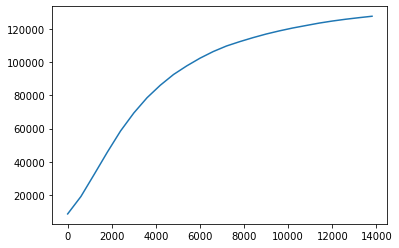

In [7]:
pyplot.plot(times_sdm, sdm_precip)

## Bin

In [8]:
# constK_IC2
# Tmax, nbin, dt, scal, emin, rhow, A, k1, theta, N0 
# [14400, 32, 1.0, 1, 7.091336e-10, 1e-09, 0.0001, 1.0, 14137.166941154068, 10.0]

v_grid = [1.06370040e+00, 2.12740080e+00, 4.25480160e+00, 8.50960320e+00,
 1.70192064e+01, 3.40384128e+01, 6.80768256e+01, 1.36153651e+02,
 2.72307302e+02, 5.44614605e+02, 1.08922921e+03, 2.17845842e+03,
 4.35691684e+03, 8.71383368e+03, 1.74276674e+04, 3.48553347e+04,
 6.97106694e+04, 1.39421339e+05, 2.78842678e+05, 5.57685355e+05,
 1.11537071e+06, 2.23074142e+06, 4.46148284e+06, 8.92296569e+06,
 1.78459314e+07, 3.56918627e+07, 7.13837255e+07, 1.42767451e+08,
 2.85534902e+08, 5.71069804e+08, 1.14213961e+09, 2.28427922e+09]
r_grid = [6.33252487e-01, 7.97848139e-01, 1.00522566e+00, 1.26650497e+00,
 1.59569628e+00, 2.01045133e+00, 2.53300995e+00, 3.19139256e+00,
 4.02090266e+00, 5.06601990e+00, 6.38278511e+00, 8.04180532e+00,
 1.01320398e+01, 1.27655702e+01, 1.60836106e+01, 2.02640796e+01,
 2.55311404e+01, 3.21672213e+01, 4.05281592e+01, 5.10622809e+01,
 6.43344425e+01, 8.10563184e+01, 1.02124562e+02, 1.28668885e+02,
 1.62112637e+02, 2.04249124e+02, 2.57337770e+02, 3.24225274e+02,
 4.08498247e+02, 5.14675540e+02, 6.48450547e+02, 8.16996494e+02]

gr0 = [2.40084895e-003, 9.60267324e-003, 3.84049132e-002, 1.53573426e-001,
 6.13924051e-001, 2.45274166e+000, 9.78737296e+000, 3.89614226e+001,
 1.54351960e+002, 6.05629257e+002, 2.33096767e+003, 8.63246975e+003,
 2.95987046e+004, 8.69937376e+004, 1.87870491e+005, 2.19048227e+005,
 7.44461241e+004, 2.14974427e+003, 4.48142597e-001, 4.86872324e-009,
 1.43665609e-025, 3.12729096e-059, 3.70458223e-127, 1.29963425e-263,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]
gr36 = [2.98559824e-04, 1.19419301e-03, 4.77651433e-03, 1.91040536e-02,
 7.64003216e-02, 3.05474505e-01, 1.22088566e+00, 4.87546624e+00,
 1.94375934e+01, 7.72414802e+01, 3.04975219e+02, 1.18914850e+03,
 4.52644931e+03, 1.64565280e+04, 5.46622883e+04, 1.47748040e+05,
 2.32311059e+05, 1.35264052e+05, 1.89178445e+04, 3.98559901e+02,
 7.87565060e-01, 1.21932014e-04, 1.83250771e-09, 2.23238827e-15,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
gr144 = [3.28956962e-05, 1.31579373e-04, 5.26306945e-04, 2.10515203e-03,
 8.42002216e-03, 3.36754481e-02, 1.34664846e-01, 5.38365495e-01,
 2.15113501e+00, 8.58629309e+00, 3.42046801e+01, 1.35771130e+02,
 5.35649753e+02, 2.09273774e+03, 8.04654300e+03, 2.97871959e+04,
 9.30290379e+04, 1.99147339e+05, 2.07558787e+05, 6.71928275e+04,
 4.27817015e+03, 3.31744392e+01, 2.12968190e-02, 1.19591002e-06,
 6.57211509e-12, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
t_bott = [    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,   800.,
   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,  1600.,  1700.,
  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,  2400.,  2500.,  2600.,
  2700.,  2800.,  2900.,  3000.,  3100.,  3200.,  3300.,  3400.,  3500.,
  3600.,  3700.,  3800.,  3900.,  4000.,  4100.,  4200.,  4300.,  4400.,
  4500.,  4600.,  4700.,  4800.,  4900.,  5000.,  5100.,  5200.,  5300.,
  5400.,  5500.,  5600.,  5700.,  5800.,  5900.,  6000.,  6100.,  6200.,
  6300.,  6400.,  6500.,  6600.,  6700.,  6800.,  6900.,  7000.,  7100.,
  7200.,  7300.,  7400.,  7500.,  7600.,  7700.,  7800.,  7900.,  8000.,
  8100.,  8200.,  8300.,  8400.,  8500.,  8600.,  8700.,  8800.,  8900.,
  9000.,  9100.,  9200.,  9300.,  9400.,  9500.,  9600.,  9700.,  9800.,
  9900., 10000., 10100., 10200., 10300., 10400., 10500., 10600., 10700.,
 10800., 10900., 11000., 11100., 11200., 11300., 11400., 11500., 11600.,
 11700., 11800., 11900., 12000., 12100., 12200., 12300., 12400., 12500.,
 12600., 12700., 12800., 12900., 13000., 13100., 13200., 13300., 13400.,
 13500., 13600., 13700., 13800., 13900., 14000., 14100., 14200., 14300.,
 14400.]
M0_bott = [9.9993864 , 9.53739   , 9.11624327, 8.73075626, 8.37658217, 8.05005303,
 7.7480523 , 7.467915  , 7.20734879, 6.96437102, 6.73725812, 6.52450466,
 6.32478984, 6.13695005, 5.95995616, 5.79289463, 5.63495175, 5.48540032,
 5.34358851, 5.2089303 , 5.08089741, 4.95901232, 4.84284237, 4.73199458,
 4.62611119, 4.52486584, 4.42796016, 4.33512087, 4.24609716, 4.16065844,
 4.07859235, 3.99970298, 3.9238093 , 3.85074382, 3.78035128, 3.71248759,
 3.64701885, 3.58382043, 3.52277622, 3.46377789, 3.40672426, 3.35152071,
 3.29807865, 3.24631508, 3.19615213, 3.14751665, 3.1003399 , 3.05455722,
 3.01010768, 2.96693387, 2.92498163, 2.88419982, 2.84454012, 2.80595683,
 2.76840669, 2.73184874, 2.69624415, 2.6615561 , 2.62774964, 2.59479156,
 2.56265031, 2.53129589, 2.50069975, 2.47083468, 2.4416748 , 2.41319541,
 2.38537294, 2.35818494, 2.33160992, 2.30562738, 2.28021773, 2.25536221,
 2.23104289, 2.2072426 , 2.18394489, 2.161134  , 2.13879483, 2.1169129 ,
 2.0954743 , 2.0744657 , 2.05387427, 2.03368773, 2.01389423, 1.9944824 ,
 1.97544132, 1.95676046, 1.93842969, 1.92043925, 1.90277976, 1.88544217,
 1.86841775, 1.85169809, 1.83527509, 1.81914091, 1.80328799, 1.78770906,
 1.77239706, 1.75734519, 1.74254688, 1.72799577, 1.71368572, 1.69961079,
 1.68576523, 1.67214348, 1.65874015, 1.64555004, 1.63256808, 1.61978941,
 1.60720926, 1.59482307, 1.58262636, 1.57061483, 1.55878429, 1.54713069,
 1.53565007, 1.52433862, 1.51319262, 1.50220847, 1.49138267, 1.48071182,
 1.47019261, 1.45982184, 1.44959638, 1.4395132 , 1.42956935, 1.41976197,
 1.41008826, 1.4005455 , 1.39113106, 1.38184236, 1.37267691, 1.36363226,
 1.35470604, 1.34589593, 1.3371997 , 1.32861514, 1.32014011, 1.31177254,
 1.30351039, 1.29535168, 1.28729448, 1.2793369 , 1.27147712, 1.26371333,
 1.2560438 ]
M1_bott = [141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.9724686 , 141374.9724686 , 141374.9724686 , 141374.9724686 ,
 141374.97246861, 141374.97246861, 141374.97246861, 141374.97246861,
 141374.97246861]
M2_bott = [3.99886046e+09, 4.18687168e+09, 4.37513223e+09, 4.56358627e+09,
 4.75219947e+09, 4.94094801e+09, 5.12981427e+09, 5.31878453e+09,
 5.50784768e+09, 5.69699430e+09, 5.88621620e+09, 6.07550607e+09,
 6.26485725e+09, 6.45426365e+09, 6.64371963e+09, 6.83322000e+09,
 7.02275998e+09, 7.21233523e+09, 7.40194178e+09, 7.59157607e+09,
 7.78123496e+09, 7.97091564e+09, 8.16061570e+09, 8.35033305e+09,
 8.54006590e+09, 8.72981279e+09, 8.91957245e+09, 9.10934391e+09,
 9.29912633e+09, 9.48891907e+09, 9.67872164e+09, 9.86853363e+09,
 1.00583548e+10, 1.02481848e+10, 1.04380236e+10, 1.06278709e+10,
 1.08177267e+10, 1.10075908e+10, 1.11974632e+10, 1.13873436e+10,
 1.15772320e+10, 1.17671283e+10, 1.19570321e+10, 1.21469434e+10,
 1.23368619e+10, 1.25267875e+10, 1.27167197e+10, 1.29066584e+10,
 1.30966033e+10, 1.32865540e+10, 1.34765103e+10, 1.36664719e+10,
 1.38564384e+10, 1.40464095e+10, 1.42363850e+10, 1.44263644e+10,
 1.46163476e+10, 1.48063341e+10, 1.49963238e+10, 1.51863164e+10,
 1.53763115e+10, 1.55663091e+10, 1.57563087e+10, 1.59463103e+10,
 1.61363137e+10, 1.63263187e+10, 1.65163251e+10, 1.67063327e+10,
 1.68963416e+10, 1.70863516e+10, 1.72763625e+10, 1.74663744e+10,
 1.76563871e+10, 1.78464006e+10, 1.80364150e+10, 1.82264301e+10,
 1.84164461e+10, 1.86064627e+10, 1.87964802e+10, 1.89864985e+10,
 1.91765177e+10, 1.93665377e+10, 1.95565586e+10, 1.97465805e+10,
 1.99366034e+10, 2.01266274e+10, 2.03166525e+10, 2.05066787e+10,
 2.06967061e+10, 2.08867348e+10, 2.10767649e+10, 2.12667963e+10,
 2.14568291e+10, 2.16468633e+10, 2.18368991e+10, 2.20269364e+10,
 2.22169753e+10, 2.24070158e+10, 2.25970579e+10, 2.27871017e+10,
 2.29771472e+10, 2.31671944e+10, 2.33572432e+10, 2.35472939e+10,
 2.37373462e+10, 2.39274003e+10, 2.41174560e+10, 2.43075135e+10,
 2.44975727e+10, 2.46876336e+10, 2.48776961e+10, 2.50677603e+10,
 2.52578261e+10, 2.54478934e+10, 2.56379623e+10, 2.58280328e+10,
 2.60181047e+10, 2.62081780e+10, 2.63982527e+10, 2.65883288e+10,
 2.67784061e+10, 2.69684847e+10, 2.71585645e+10, 2.73486455e+10,
 2.75387275e+10, 2.77288106e+10, 2.79188947e+10, 2.81089798e+10,
 2.82990657e+10, 2.84891524e+10, 2.86792400e+10, 2.88693283e+10,
 2.90594172e+10, 2.92495068e+10, 2.94395969e+10, 2.96296876e+10,
 2.98197787e+10, 3.00098703e+10, 3.01999622e+10, 3.03900545e+10,
 3.05801471e+10, 3.07702399e+10, 3.09603330e+10, 3.11504262e+10,
 3.13405195e+10]
mprecip_bin = [   496.79993706,    775.46512486,   1109.18042958,   1498.95863498,
   1945.39341453,   2448.59952645,   3008.21401644,   3623.42543944,
   4293.0169296 ,   5015.41577303,   5788.74519889,   6610.87572244,
   7479.4743422 ,   8392.05052721,   9345.99836728,  10338.63456874,
  11367.23219932,  12429.05024173,  13521.35912367,  14641.46246328,
  15786.71531267,  16954.53920554,  18142.43432261,  19347.98908512,
  20568.8874761 ,  21802.91437242,  23047.9591514 ,  24302.01781435,
  25563.19384746,  26829.69801864,  28099.84728757,  29372.06298633,
  30644.86840887,  31916.88593042,  33186.83376192,  34453.52243013,
  35715.85106125,  36972.80353418,  38223.44455936,  39466.91573015,
  40702.43158558,  41929.27571656,  43146.79694152,  44354.40557224,
  45551.56978616,  46737.81211765,  47912.70607739,  49075.87290636,
  50226.97846835,  51365.73028343,  52491.87470253,  53605.19422275,
  54705.50494113,  55792.65414442,  56866.51803128,  57926.99956301,
  58974.0264384 ,  60007.54918815,  61027.5393839 ,  62033.98795708,
  63026.90362241,  64006.3114012 ,  64972.25123939,  65924.7767156 ,
  66863.9538342 ,  67789.85989908,  68702.58246336,  69602.21835085,
  70488.87274512,  71362.65834216,  72223.69456277,  73072.10682119,
  73908.02584638,  74731.58705271,  75542.92995701,  76342.19763894,
  77129.53624193,  77905.0945121 ,  78669.02337263,  79421.47553121,
  80162.60511849,  80892.56735528,  81611.51824678,  82319.61430177,
  83017.01227522,  83703.86893267,  84380.34083479,  85046.58414085,
  85702.75442962,  86349.00653666,  86985.49440658,  87612.37095946,
  88229.78797022,  88837.89596011,  89436.84409936,  90026.78012025,
  90607.85023971,  91180.19909089,  91743.96966291,  92299.30324816,
  92846.33939671,  93385.21587713,  93916.06864325,  94439.0318065 ,
  94954.23761323,  95461.81642676,  95961.89671362,  96454.60503379,
  96940.0660345 ,  97418.4024473 ,  97889.73508821,  98354.18286054,
  98811.86276023,  99262.88988352,  99707.37743662, 100145.43674729,
 100577.17727809, 101002.70664113, 101422.1306143 , 101835.55315857,
 102243.07643646, 102644.80083153, 103040.82496862, 103431.2457349 ,
 103816.15830157, 104195.65614612, 104569.83107505, 104938.77324704,
 105302.57119642, 105661.31185691, 106015.08058559, 106363.96118705,
 106708.03593757, 107047.38560943, 107382.08949527, 107712.2254323 ,
 108037.86982663, 108359.09767738, 108675.98260076, 108988.59685394,
 109297.01135887, 109601.29572578, 109901.51827659, 110197.74606805,
 110490.04491465]


In [9]:
gr_0 = np.array(gr0)
gr_f = np.array(gr144) # um**3/cm3
r_grid = np.array(r_grid)
r_grid = np.insert(r_grid, 0, 0.0)

In [10]:
v_grid_plt = np.array(v_grid)*np.sqrt(2)
r_grid_plt = (v_grid_plt / 4 / np.pi * 3)**(1/3)

## Cloudy

In [11]:
# import rbf from julia setup
from scipy.stats import norm
from scipy.stats import gamma

def cslogrbf1(x, mean, stddev):
    r = abs((np.log(x)-mean)/stddev)
    cslogr = np.zeros(len(x))
    for (i, ri) in enumerate(r):
        if (ri < 1):
            cslogr[i] = 12/35*(1-ri)**4 * (4+16*ri+12*ri**2+3*ri**3)/x[i]/stddev
    return cslogr

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*cslogrbf1(x, means[i], stddev[i])
        
    return pdf_result

def rbf8_i(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_init = [0.011319209813756295, 5.007971833138832e-6, 2.167500100814402, 5.8877621048338495, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_init, means, stddevs)

def rbf8_f(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_final = [0.0, 0.0005888785525144872, 0.04510816751079085, 0.19872235692472914, 0.8701781119452879, 0.0, 0.0, 4.998115081230154e-6]
    return rbf_basis(x, c_final, means, stddevs)

def rbf16_i(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_init = [9.705174773414926e-7, 0.12057762502197195, 0.09446231101681898, 0.275606184504158, 0.6998802079551418, 1.5890963874552382, 3.1355930770990152, 3.6885910551117798, 0.2395261260779029, 8.071150668242785e-8, 2.621979216442597e-8, 1.3915775033823228e-8, 1.1191120200057128e-8, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_init, means, stddevs)

def rbf16_f(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_final = [0.0, 0.0019228200152022802, 0.0015044547781420334, 0.004510625951474005, 0.011594930177526048, 0.029529084465640607, 0.06929748864105068, 0.16908365935942227, 0.3285886084198149, 0.45701234884680986, 0.12892376438162545, 0.0, 0.0, 5.102080155946112e-6, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)
    
#import cloudy from julia setup
# GAMMA CASE
# initial N, k, theta = 10.0, 1.0, 14137.166941154068, 
# final N, k, theta = 2.172266436663165, 0.12184759368279498, 534112.002542168, 
# def mom_f(x):
#     n = 2.172266436663165,
#     k = 0.12184759368279498
#     theta = 534112.002542168
#     return n*gamma.pdf(x, k, scale=theta)
# def mom_i(x):
#     n =10.0
#     k =1.0
#     theta = 14137.166941154068
#     return n*gamma.pdf(x, k, scale=theta)

# EXP CASE
# initial N, k, theta = 10.0, 1.0, 14137.166941154068, 
# final N, k, theta = 1.219512198978067, 1.0, 115924.7685509075, 
def mom_f(x):
    n = 1.219512198978067,
    k = 1.0
    theta = 115924.7685509075
    return n*gamma.pdf(x, k, scale=theta)
def mom_i(x):
    n =10.0
    k =1.0
    theta = 14137.166941154068
    return n*gamma.pdf(x, k, scale=theta)
    

In [12]:
col_8_times = [0.0, 0.464121137470687, 4.91675972573934, 49.443145608425866, 236.93931329260676, 373.7712611136632, 842.8950620586422, 1332.272014161919, 2200.971596346484, 3094.1939949874723, 4365.256906240911, 5882.642854125202, 7894.134305874761, 10337.329386950081, 13488.534525025236, 14400.0]
col_8_M_0 = [8.0609262822703, 8.059438695229515, 8.045196115151931, 7.905506674600173, 7.367113255424803, 7.018647574856103, 6.0401425408996126, 5.272844831213362, 4.298683598403787, 3.606110694048175, 2.9240345846503764, 2.374828626542169, 1.8904397478986446, 1.5055907144236382, 1.1845841470105654, 1.1145381128015301]
col_8_M_1 = [141371.88186888164, 141407.84308207405, 141752.65225929522, 145160.1926486191, 158711.9662410914, 167751.50274553188, 193427.78662914378, 212435.07402532166, 231441.6875308681, 237988.7302814169, 234974.44996964408, 222871.11027512237, 202879.27660988015, 179491.55040795146, 154134.40229960188, 147829.98399230448]
col_8_M_2 = [8.551692480400762e9, 8.577183589115316e9, 8.821595259062845e9, 1.1241104864035276e10, 2.0942860952050503e10, 2.7496709044846508e10, 4.665337981055054e10, 6.176182121383234e10, 7.920077315395657e10, 8.865611581268562e10, 9.364328407071194e10, 9.308227500043858e10, 8.809408074146724e10, 8.046811903054625e10, 7.122623132394429e10, 6.882727256194595e10]

col_16_times = [0.0, 0.43097698316448757, 3.9326766269473787, 27.42814914323814, 154.9375725659041, 422.7515897929102, 792.3713362105543, 1337.4849199005498, 2027.4655912707622, 2390.63621748538, 3353.4481293108365, 4241.0708474917365, 5713.572034047088, 7399.006588283388, 9699.17741297379, 11610.79717007402, 14400.0]
col_16_M_0 = [9.814608425077534, 9.81255894270546, 9.795938629082938, 9.685845399124, 9.128508335090329, 8.140467797169341, 7.072683215261163, 5.906677901597067, 4.871124311698175, 4.475978019871553, 3.684234249394054, 3.1653763813996876, 2.558469070629749, 2.087663408772336, 1.6746284895980337, 1.4442264437804424, 1.20151481427351]
col_16_M_1 = [141371.06401646842, 141378.00619976665, 141434.43414174352, 141805.65933783888, 143593.76361549384, 146108.42696171915, 147094.7180557842, 144665.1776427358, 139681.88953390028, 141698.18410296415, 145904.3675571801, 147579.76343194133, 146057.12838512126, 140087.08046544317, 138682.4308782103, 142055.99678782714, 144091.16935090243]
col_16_M_2 = [4.35033827315877e9, 4.352137991878664e9, 4.3671414620369625e9, 4.466645380811573e9, 4.98339184146645e9, 5.913932208825005e9, 6.883589365338642e9, 7.784875400047405e9, 8.466875429827993e9, 9.934303089460058e9, 1.3500206835969501e10, 1.6099697005911781e10, 1.896209062501773e10, 2.062198802974379e10, 2.555128081087989e10, 3.2461078394534966e10, 4.0286176272929985e10]


In [13]:
# EXP CASE
t_cloudy = [0.0, 0.04995598605649359, 0.5495158466214294, 5.545114452270788, 34.47852177863827, 84.01363351074818, 143.23896736824932, 217.57766452827684, 304.2046464535496, 404.8984921514526, 518.6173519569962, 645.8768140222396, 786.3949649149423, 940.4299596485189, 1108.0956715864913, 1289.7430116625212, 1485.762605328344, 1696.6879002821847, 1923.1493841656484, 2165.8911794224155, 2425.7597177750704, 2703.7121997782533, 3000.8137836958635, 3318.2422185824717, 3657.2906405898857, 4019.373287421037, 4406.031372502072, 4818.941038513612, 5259.922085658996, 5730.948526012368, 6234.159961112588, 6771.8753020870045, 7346.607302904538, 7961.079547331405, 8618.244641635254, 9321.305323313734, 10073.736853405322, 10879.313259584314, 11742.13503005923, 12666.661086615664, 13657.743327054208, 14400.0]
M0_cloudy = [10.0, 9.999750226308521, 9.997253175478225, 9.972351085930395, 9.830528946777276, 9.596866200045753, 9.33167057165666, 9.018849855754995, 8.679784597624636, 8.316359324891769, 7.940864850349535, 7.558930898545045, 7.177733328313861, 6.801726374337354, 6.434808360237505, 6.0795022422913005, 5.737625387860298, 5.410248461486354, 5.097945061870998, 4.800893535999885, 4.51899816423003, 4.251960833361584, 3.999349088913627, 3.760641060007678, 3.535261192907126, 3.322605046713626, 3.122057777079066, 2.933006746556582, 2.754850511842277, 2.5870046876210218, 2.4289059446955634, 2.2800141808371364, 2.139813884854414, 2.0078145134049143, 1.8835505076474695, 1.7665807532009212, 1.656487989400752, 1.5528778344484064, 1.455377933491975, 1.363636887830514, 1.277323280721803, 1.2195121989780668]
M1_cloudy = [141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067]
M2_cloudy = [3.997189782441189e9, 3.997289624219724e9, 3.998288042005079e9, 4.0082722198586345e9, 4.066098379936697e9, 4.165099001194924e9, 4.283466450886043e9, 4.432039391242945e9, 4.605171634714397e9, 4.806417840168551e9, 5.033695772149105e9, 5.288035882442813e9, 5.56887474026592e9, 5.87672829286757e9, 6.211824126948289e9, 6.574863571289168e9, 6.966627327915947e9, 7.388181542669933e9, 7.840786304931617e9, 8.325928814017518e9, 8.845300744047216e9, 9.400815151161743e9, 9.994600855228107e9, 1.0629011699492075e10, 1.1306632139262695e10, 1.2030288662791239e10, 1.280306153136243e10, 1.3628300675182497e10, 1.4509643137652906e10, 1.5451034169238234e10, 1.6456749966669428e10, 1.753142509391573e10, 1.8680081528273403e10, 1.99081626104128e10, 2.1221569404229187e10, 2.2626702884646282e10, 2.4130508690782627e10, 2.5740529575277374e10, 2.746496075318727e10, 2.9312713803163105e10, 3.129348570381036e10, 3.2776956112376526e10]
t_precip_mom = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_mom = [7766.397392679327, 10037.33121473735, 12520.953391110434, 15175.1344084481, 17959.87886449621, 20838.708018834062, 23779.316199695386, 26753.744174473988, 29738.25048315966, 32713.009440034806, 35661.724729149944, 38571.211519736746, 41430.982355203, 44232.85918020389, 46970.6260744225, 49639.7069775658, 52236.89773412921, 54760.12782512141, 57208.25158689628, 59580.88661018405, 61878.253530327114, 64101.06950542147, 66250.42959854586, 68327.736461156, 70334.61728249703, 72272.87308867571, 74144.42841352856, 75951.28774812228, 77695.51375528434, 79379.18731317382, 81004.39820887886, 82573.22365357184, 84087.71108874361, 85549.87769940571, 86961.69290918796, 88325.07451616488, 89641.89073915618, 90913.94846774069, 92142.99382510164, 93330.71616151964, 94478.74163333821, 95588.63356990925, 96661.89698424088, 97699.97874781206, 98704.26468582156, 99676.08374249512, 100616.71299587838, 101527.37422971599, 102409.23668601435, 103263.42007242516, 104090.99874117934, 104892.99882989789, 105670.40203674264, 106424.14766414644, 107155.13659757817, 107864.22940116249, 108552.24905851323, 109219.98263640182, 109868.1850156514, 110497.57868707318, 111108.853639473, 111702.67081742859, 112279.66291074183, 112840.43708349051, 113385.57418257081, 113915.62977656955, 114431.13637857781, 114932.60434895518, 115420.52381565423, 115895.36420922211, 116357.57479014636, 116807.58692016223, 117245.81400080612, 117672.65359957631, 118088.48730974605, 118493.68061080277, 118888.58469831894, 119273.5364763348, 119648.85994111294, 120014.86689588972, 120371.85686537661, 120720.11711209014, 121059.92425096486, 121391.54389447559, 121715.23185399252, 122031.23466158197, 122339.78955352453, 122641.1244684163, 122935.45882590875, 123223.00412758454, 123503.963846309, 123778.53445791232, 124046.9054587039, 124309.25938560207, 124565.7718486948, 124816.6123144081, 125061.94441693109, 125301.92601521323, 125536.70954135069, 125766.44203049276]


In [14]:
t_precip_8 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_8 = [46094.25145425666, 60469.51215383869, 73891.34675757683, 86327.6038763089, 97799.62732613056, 108342.47463543898, 117999.43343759757, 126819.3467918413, 134852.96898263198, 142151.21840305493, 148764.48490838223, 154741.55314464102, 160129.0509242784, 164971.08732123402, 169309.24636448934, 173182.58703806752, 176627.67716831723, 179678.3916784882, 182366.14917384335, 184720.21761109348, 186767.71656178648, 188533.6172123079, 190040.9634301061, 191311.10713502284, 192363.3482925228, 193215.70139051572, 193884.92969537282, 194386.54525192728, 194734.80888347497, 194942.73019177315, 195022.0675570421, 194983.86923297695, 194838.35307612197, 194594.63258249997, 194261.2516693768, 193846.18473856163, 193356.83667640632, 192800.04285380623, 192182.06912619926, 191508.61183356668, 190784.7978004327, 190015.31593870436, 189204.88758874813, 188357.4481391476, 187476.6406211768, 186565.89686071, 185628.4374782221, 184667.2718887886, 183685.1983020853, 182684.8037223885, 181668.46394857502, 180638.34357412218, 179596.3959871076, 178544.36337020967, 177483.77670070707, 176416.10694101857, 175342.9583583804, 174265.53423052558, 173184.95503767132, 172102.27810689717, 171018.49761214596, 169934.54457422352, 168851.28686079866, 167769.529186403, 166690.0131124315, 165613.4170471419, 164540.35624565493, 163471.38280995458, 162406.98568888745, 161347.59067816343, 160293.5604203552, 159245.1944048988, 158202.8527954727, 157166.92070295167, 156137.62517955835, 155115.17827739642, 154099.77768609696, 153091.60673281876, 152090.83438224823, 151097.61523659938, 150112.08953561354, 149134.3831565602, 148164.60761423598, 147202.86006096526, 146249.22328659997, 145303.76571851977, 144366.54142163173, 143437.59009837074, 142516.93708869893, 141604.59337010657, 140700.55555761093, 139804.80590375725, 138917.31229861843, 138038.03104976218, 137166.96767984433, 136304.11275423522, 135449.43498263427, 134602.89879144658, 133764.46432378326, 132934.08743946085]
t_precip_16 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_16 = [11547.595626181239, 16586.433244847434, 21206.58324558014, 25381.329283614527, 29109.778609966048, 32407.530548647646, 35299.62095255242, 37816.704200870205, 39991.36779457555, 41856.038218322916, 43444.1728104036, 44783.34367515016, 45897.22958986053, 46800.716766109166, 49661.529210152294, 52921.36195143563, 56101.06720127093, 59188.63683943136, 62174.626518357734, 65052.123684735285, 67815.7781369381, 70461.72535216194, 72987.58648642531, 75392.46837456914, 77676.52621899433, 79840.52083028067, 81886.04038045034, 83815.13219223724, 85630.30162181117, 87334.51205877888, 88931.0158130922, 90423.22794260489, 91814.87963005994, 93109.7002789047, 94311.4118441053, 95423.72883214749, 96450.3583010345, 97394.99986028855, 98261.34567095047, 99053.0804455796, 99773.81836506791, 100426.92943988173, 101015.74336246698, 101543.4830192182, 102013.25760573808, 102428.06262683867, 102790.77989653997, 103104.1775380708, 103370.90998386833, 103593.51797557867, 103774.4285640562, 103915.9400179639, 104019.34720487136, 104086.73634190063, 104120.80504902809, 104124.1106616697, 104099.07023068021, 104052.67058154251, 104465.82820843386, 105376.01404055758, 106313.0906202785, 107230.98301338557, 108129.19461303485, 109007.38448960867, 109865.3673907164, 110703.11374119381, 111520.74964310363, 112318.52998505105, 113096.38386742858, 113854.31044608836, 114592.4155040207, 115310.8164616001, 116009.6423765848, 116689.03394411699, 117349.14349672299, 117990.47029421016, 118613.0119050524, 119216.99781686469, 119802.39194768737, 120369.49737447122, 120918.53726719788, 121449.71905063424, 121963.27051790239, 122459.43601991692, 122938.4612855672, 123400.59342171844, 123846.0809132109, 124275.17362286002, 124688.1227914566, 125085.18103776683, 125466.60235853202, 125832.64212846884, 126183.55710026927, 126519.60540460044, 126841.04655010495, 127148.14142340055, 127441.15228908023, 127720.34278971242, 127985.97794584067, 128238.324155984]


## Plotting

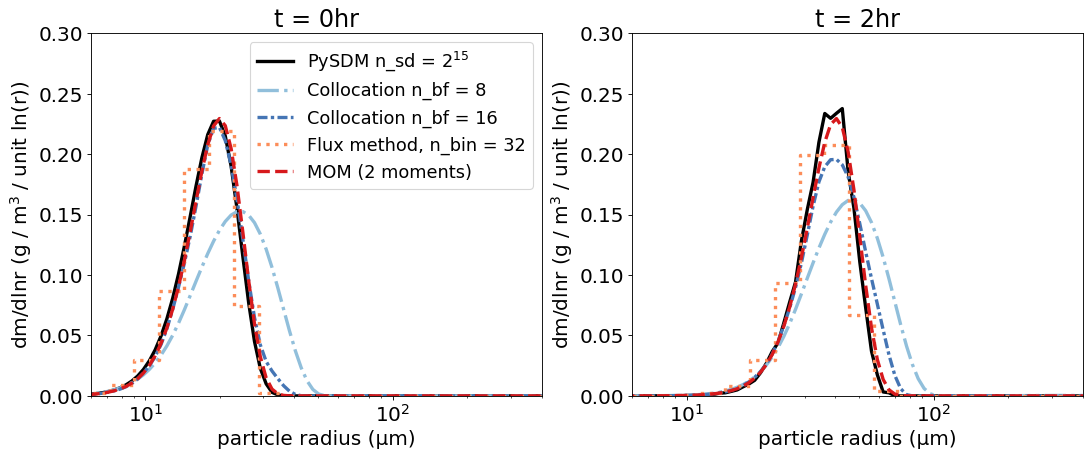

In [15]:
# plot all of them
pyplot.rcParams.update({'font.size':18})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(16,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM sdm_y1: m^3 / m^3 / (unit ln R) --> 1e6 g / m^3 / unit ln R
r_sdm = settings.radius_bins_edges[1:] / si.um
dlnr_sdm = np.log(r_sdm[2]) - np.log(r_sdm[1])

ax[0].plot(r_sdm, sdm_y1[:,0] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[1].plot(r_sdm, sdm_y1[:,-1] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)


# COLLOCATION: (um^6 / cm^3) -> 
x = settings.volume_bins_edges[:-1]/si.um**3
yrbf8i = rbf8_i(x)
yrbf8f = rbf8_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf8i * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)#, label='Collocation n_bf = 8, init')
ax[1].plot(r_sdm, 3*x*x*yrbf8f * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)
yrbf16i = rbf16_i(x)
yrbf16f = rbf16_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf16i * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)#, label='Collocation n_bf = 16, init')
ax[1].plot(r_sdm, 3*x*x*yrbf16f * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].step(r_grid_plt,
            gr_0 * si.cm**3,
            linestyle=ls[3],color=colors[3],label='Flux method, n_bin = 32', linewidth=3)#, label='Flux method, n_bin = 32, init')
ax[1].step(r_grid_plt,  
            gr_f * si.cm**3,
            linestyle=ls[3],color=colors[3], label='Flux method, n_bin = 32',linewidth=3)


# BULK: (um^3 / cm^3) / (um^3)
ymomi = mom_i(x)
ymomf = mom_f(x)
ax[0].plot(r_sdm, 3*x*x*ymomi * si.cm**3, linestyle=ls[4],color=colors[4],label="MOM (2 moments)",linewidth=3)#, label="MOM (3 moments), init")
ax[1].plot(r_sdm, 3*x*x*ymomf * si.cm**3, linestyle=ls[4],color=colors[4], label="MOM (2 moments)",linewidth=3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("particle radius (µm)")
#ax[0].set_ylabel("volume density µm$^3$/cm$^3$ per um$^3$")
ax[0].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[1].set_xlabel("particle radius (µm)")
ax[1].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[0].set_xlim([6.0, 400.0])
ax[1].set_xlim([6.0, 400.0])
ax[0].set_ylim([0.0, 0.3])
ax[1].set_ylim([0.0, 0.3])
ax[0].legend(fontsize=16)

ax[0].set_title('t = 0hr')
ax[1].set_title('t = 2hr')

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

#ax[0].grid()
#ax[1].grid()

pyplot.savefig("m(v)_constant_IC2.pdf", transparent=True)

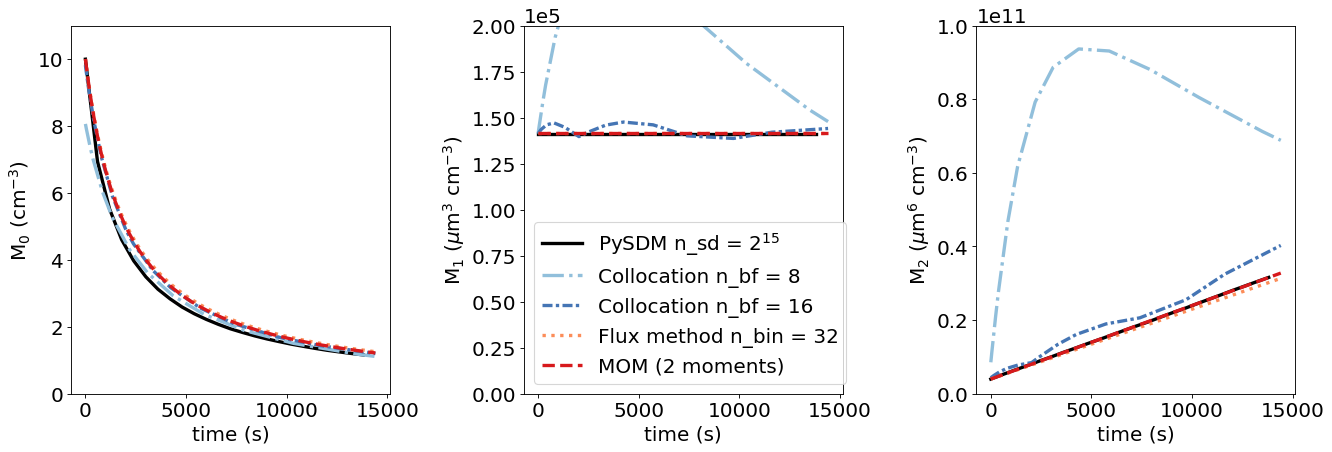

In [16]:
# plot all of them
from matplotlib.ticker import ScalarFormatter
xfmt = ScalarFormatter()
xfmt.set_powerlimits((-3,3))  # Or whatever your limits are . . .

fig, ax = pyplot.subplots(nrows=1, ncols=3, figsize=(17,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM:
ax[0].plot(times_sdm, mom0*si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
ax[1].plot(times_sdm, mom1 / si.um**3 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[2].plot(times_sdm, mom2 / si.um**6 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)

# COLLOCATION:
ax[0].plot(col_8_times, col_8_M_0, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[1].plot(col_8_times, col_8_M_1, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[2].plot(col_8_times, col_8_M_2, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)

ax[0].plot(col_16_times, col_16_M_0, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[1].plot(col_16_times, col_16_M_1, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[2].plot(col_16_times, col_16_M_2, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].plot(t_bott, M0_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[1].plot(t_bott, M1_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[2].plot(t_bott, M2_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)

# # BULK: (um^3 / cm^3) / (um^3)
ax[0].plot(t_cloudy, M0_cloudy, color=colors[4],linestyle=ls[4], label='MOM (2 moments)',linewidth=3)
ax[1].plot(t_cloudy, M1_cloudy, color=colors[4],linestyle=ls[4], label='MOM (2 moments)',linewidth=3)
ax[2].plot(t_cloudy, M2_cloudy, color=colors[4],linestyle=ls[4], label='MOM (2 moments)',linewidth=3)

ax[0].set_xlabel('time (s)')
ax[1].set_xlabel('time (s)')
ax[2].set_xlabel('time (s)')
ax[0].set_ylabel('M$_0$ (cm$^{-3}$)')
ax[1].set_ylabel('M$_1$ ($\mu$m$^3$ cm$^{-3}$)')
ax[2].set_ylabel('M$_2$ ($\mu$m$^6$ cm$^{-3}$)')
ax[0].set_ylim([0, 11])
ax[1].set_ylim([0, 2e5])
ax[2].set_ylim([0, 1e11])
ax[1].legend()
ax[1].yaxis.set_major_formatter(xfmt)

pyplot.tight_layout()
pyplot.savefig("moments_constant_IC2.pdf", transparent=True)


In [17]:
volume_cutoff = 4/3*np.pi*r_cutoff**3

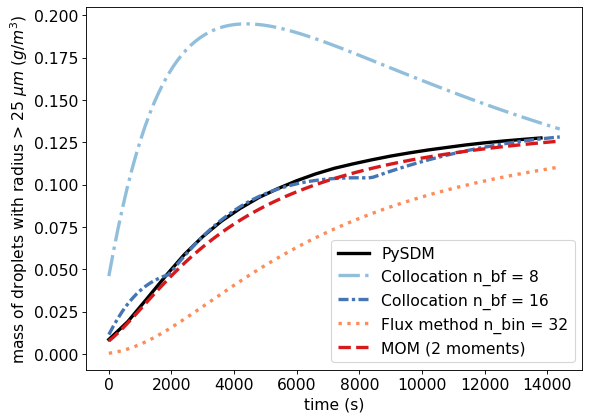

In [18]:
# plot all of them
pyplot.rcParams.update({'font.size':14})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(times_sdm, sdm_precip[:] / 1e6, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
pyplot.plot(t_precip_8, np.divide(m_precip_8, 1e6), color=colors[1], linestyle=ls[1],label='Collocation n_bf = 8',linewidth=3)
pyplot.plot(t_precip_16, np.divide(m_precip_16, 1e6), color=colors[2], linestyle=ls[2],label='Collocation n_bf = 16',linewidth=3)
pyplot.plot(t_bott, np.divide(mprecip_bin, 1e6), color=colors[3], linestyle=ls[3],label='Flux method n_bin = 32',linewidth=3)
pyplot.plot(t_precip_mom, np.divide(m_precip_mom, 1e6), color=colors[4], linestyle=ls[4],label='MOM (2 moments)',linewidth=3)
pyplot.xlabel('time (s)')
pyplot.ylabel('mass of droplets with radius > 25 $\mu m$ $(g / m^3)$')
pyplot.legend()
pyplot.gca().yaxis.set_major_formatter(xfmt)
pyplot.savefig('m_precip_constant_IC2.pdf', transparent=True)

## Error Computation

In [20]:
import pickle

def compute_L2_error(y1, y2):
    return np.linalg.norm(y1-y2)/np.linalg.norm(y2)

def bott_m_f(x):
    mf = np.zeros(len(x))
    dlnr_bin = np.mean(np.log(r_grid[2:]) - np.log(r_grid[1:-1]))
    for i in range(len(x)):
        i0 = find_nearest(v_grid,x[i])[0]
        mf[i] = gr_f[i0]#/dlnr_bin*dlnr
    return mf

v_sdm = x

yrbf8f = rbf8_f(v_sdm)
e8f = compute_L2_error(3*yrbf8f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

yrbf16f = rbf16_f(v_sdm)
e16f = compute_L2_error(3*yrbf16f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ymomf = mom_f(v_sdm)
emomf = compute_L2_error(3*ymomf*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ybinf = bott_m_f(v_sdm)
ebinf = compute_L2_error(ybinf*1e-6, sdm_y1[:,-1]*1e6)

print(e8f,e16f,emomf,ebinf)
errs = [e8f, e16f, emomf, ebinf]
pickle.dump(errs, open("constant_IC2_errors.pkl", "wb" ))

0.5154156077157581 0.23116412423877905 0.09393563541110742 0.2122604737613626
